In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import spacy
from tqdm import tqdm
from collections import defaultdict
from datasets import load_metric, load_dataset, load_from_disk
from differ import diff_ratio
import re
import seaborn as sns
import json
from tqdm import tqdm

In [3]:
os.environ['HF_DATASETS_CACHE'] = '/data/users/k1897038/.cache/huggingface/datasets'
os.environ['TRANSFORMERS_CACHE'] = '/data/users/k1897038/.cache/huggingface/transformers'

In [11]:
os.getcwd()

'/data/users/k1897038/mimic_summarisation/extractive_approach'

In [17]:
for line in tqdm(open('../../hadms_to_hosp_course_processed.jsonl')):
    ents = json.loads(line)
    break

In [ ]:
cat_ents = load_dataset('json', data_files='../../hadms_to_hosp_course_processed.jsonl') 

In [5]:
ds = load_dataset('json', data_files=ds_path)

Using custom data configuration default-b3aeb80e4ba19d32
Reusing dataset json (/home/k1897038/.cache/huggingface/datasets/json/default-b3aeb80e4ba19d32/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
pat = re.compile(r'(?:brief)?\n?\s?hospital course:?|SUMMARY OF HOSPITAL COURSE BY SYSTEMS:?', re.IGNORECASE)
def clean(s: str):
    s = s.replace('\n\n' ,'\n')\
         .replace(r'\s{2+}', ' ')\
         .replace(r'\t', ' ')
    return pat.sub('', s)

In [7]:
ds = ds['train'].map(lambda d: {'clean_sum': clean(d['summary'])}, num_proc=5)

In [8]:
ds = ds.map(lambda d: {'clean_text': clean(d['text'])}, num_proc=10)

In [9]:
nlp = spacy.load('en_core_web_md')
nlp.add_pipe('sentencizer')

In [37]:
# disable_steps = ["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]
# def find_sents(text):
#     return [s.text for s in nlp(text, disable=disable_steps).sents]

In [12]:
tok = nlp.tokenizer
sentensizer = nlp.pipeline[-1][-1]
def find_sents(text):
    return [s.text for s in sentensizer(tok(text)).sents if len(s) > 3]

In [13]:
ds = ds.map(lambda d: {'summ_sents': find_sents(d['clean_sum'])})

  0%|          | 0/47951 [00:00<?, ?ex/s]

In [ ]:
ds['summ_sents']

In [16]:
ds = ds.map(lambda d: {'text_sents': find_sents(d['clean_text'])})

  0%|          | 0/47951 [00:00<?, ?ex/s]

In [21]:
ds.save_to_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [ ]:
ds = load_from_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [5]:
# train 6 seperate LSTM models for prediciting 'top-line' extractive summaries.
sent_limits = [1,2,3,5,10,15]

In [7]:
sent_limd_sums = defaultdict(list)
for lim in tqdm(sent_limits):
    ds = ds.map(lambda d: {f'summ_lim_{lim}': d['summ_sents'][:lim]}, num_proc=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [14:05<00:00, 140.93s/it]


In [8]:
def _parse_score(lvl, scores):
    return (lvl, scores[lvl].mid.precision, scores[lvl].mid.recall, scores[lvl].mid.fmeasure)

In [12]:
input_lens = ds.map(lambda d: {'lens': len(d['text_sents'])})

  0%|          | 0/47951 [00:00<?, ?ex/s]

<AxesSubplot:ylabel='Count'>

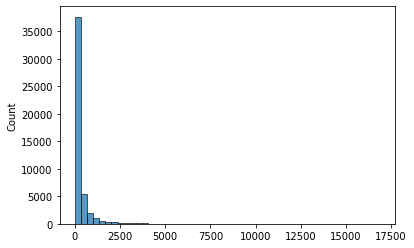

In [23]:
sns.histplot(input_lens['lens'], stat='count', bins=50)

In [28]:
len([i for i in input_lens['lens'] if i < 1000]) / len(ds)

0.9378949344122125

In [ ]:
# take the top 500 of start, end of sentences. For 93% of cases this is the full amount...

In [29]:
def top_tail_text_sents(d):
    sents = d['text_sents']
    if len(d['text_sents']) > 1000:
        first = d['text_sents'][:500]
        last = d['text_sents'][-500:]
        sents = first + last
    return sents

In [ ]:
def top_tail_texts(d, col_name):
    sent_embeds = d[col_name]
    if len(d[col_name]) > 1000:
        first = d[col_name][:500]
        last = d[col_name][-500:]
        sents = first + last
    return sent_embeds

In [ ]:
ds = ds.map(lambda d: {'text_embed_limd': top_tail_text_embed(d, 'text_embed')})

In [30]:
ds = ds.map(lambda d: {'text_sents_limd': top_tail_text_sents(d, 'text_sents')})

  0%|          | 0/47951 [00:00<?, ?ex/s]

In [44]:
first_sents = ds['text_sents_limd'][1]

In [39]:
# only encode the limited text_sents.
model = SentenceTransformer('all-MiniLM-L6-v2')

In [47]:
def encode(sents):
    return [model.encode(s) for s in sents]
ds = ds.map(lambda d:{'text_embed_limd': encode(d['text_sents_limd'])})

  0%|          | 0/47951 [00:00<?, ?ex/s]

In [51]:
ds

Dataset({
    features: ['hadm_id', 'summary', 'text', 'clean_sum', 'clean_text', 'summ_sents', 'text_sents', 'text_embed', 'summ_lim_1', 'summ_lim_2', 'summ_lim_3', 'summ_lim_5', 'summ_lim_10', 'summ_lim_15', 'text_sents_limd', 'preds_lim_1', 'preds_lim_2', 'preds_lim_3', 'preds_lim_5', 'preds_lim_10', 'preds_lim_15', 'text_embed_limd'],
    num_rows: 47951
})

In [50]:
ds.save_to_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [ ]:
len(ds['text_embed_limd'].iloc[0])

In [6]:
ds = ds.map(lambda d: {'text_embed_len': len(d['text_embed_limd'])})

Loading cached processed dataset at /data/users/k1897038/mimic3_dataset_pre_processed/cache-10b471aaea75458e.arrow


In [ ]:
for lim in tqdm(sent_limits):
    col = f'summ_lim_{lim}'
    def map_preds(d):
        summ_sents = d[col]
        text_sents = d['text_sents_limd']
        sim_text_sent_idxs = []
        sents_to_compare = text_sents
        for summ_sent in summ_sents:
            sents_to_compare = [s if i not in sim_text_sent_idxs else '' 
                                for i, s in enumerate(text_sents)]
            ratios = [diff_ratio(summ_sent, sent)[0] for sent in sents_to_compare]
            max_ratio_sents = np.where(ratios == np.amax(ratios))[0]
            sim_text_sent_idxs.extend(max_ratio_sents)
        preds = np.zeros(len(text_sents))
        for i in sim_text_sent_idxs:
            preds[i] = 1
        return preds
    ds = ds.map(lambda d: {f'preds_lim_{lim}': map_preds(d)}, num_proc=10) 

In [38]:
ds.save_to_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [4]:
ds = load_from_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [5]:
ds

Dataset({
    features: ['hadm_id', 'summary', 'text', 'clean_sum', 'clean_text', 'summ_sents', 'text_sents', 'text_embed', 'summ_lim_1', 'summ_lim_2', 'summ_lim_3', 'summ_lim_5', 'summ_lim_10', 'summ_lim_15', 'text_sents_limd', 'preds_lim_1', 'preds_lim_2', 'preds_lim_3', 'preds_lim_5', 'preds_lim_10', 'preds_lim_15', 'text_embed_limd', 'text_embed_len', 'text_embed_limd_spacy', 'text_limd'],
    num_rows: 47951
})

In [ ]:
ds

In [ ]:
## use glove embeddings?? 
## re-reun LSTM?? models

In [30]:
nlp = spacy.load('en_core_web_md')

In [ ]:
ds = ds.map(lambda d: {'text_embed_limd_spacy': [nlp(s).vector for s in d['text_sents_limd']]})

  0%|          | 0/47951 [00:00<?, ?ex/s]

In [26]:
list(nlp(first_sents[0]).sents)[0].vector

300

In [10]:
ds.save_to_disk('/data/users/k1897038/mimic3_dataset_pre_processed')

In [7]:
metric = load_metric('rouge')

In [10]:
sent_limits = [1,2,3,5,10,15]

In [26]:
extractive_score_ceil = {}
for lim in tqdm(sent_limits):
    text_sums = []
    for sent_idxs, text_sents in zip([np.argwhere(np.array(p) == 1) for p in ds[f'preds_lim_{lim}']], 
                                     ds['text_sents']):
        text_sum = []
        for i in sent_idxs:
            t = text_sents[i[0]]
            if t not in text_sum:
                text_sum.append(t)
        text_sums.append(''.join(text_sum))
    metric.add_batch(predictions=text_sums, references=[''.join(s) for s in ds[f'summ_lim_{lim}']])
    scores = metric.compute()
    extractive_score_ceil[lim] = _parse_score('rouge1', scores), _parse_score('rouge2', scores), _parse_score('rougeLsum', scores)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [2:40:54<00:00, 1609.12s/it]


In [27]:
extractive_score_ceil

{1: (('rouge1', 0.2954789037242724, 0.3105789838775548, 0.26893790052938443),
  ('rouge2', 0.1530013865553545, 0.18564336298053785, 0.14916766696966413),
  ('rougeLsum', 0.2869088898344726, 0.30200243852475417, 0.2611722859785751)),
 2: (('rouge1', 0.32752561931874313, 0.32203975278645547, 0.29883012290461897),
  ('rouge2', 0.15113092568450023, 0.16597535441556202, 0.14596105283919245),
  ('rougeLsum', 0.3149819334644566, 0.3105165310723039, 0.28765856215926366)),
 3: (('rouge1', 0.3376198158858904, 0.32930108144291087, 0.31184174913281104),
  ('rouge2', 0.1449426198825109, 0.15423277917724654, 0.14023967984408575),
  ('rougeLsum', 0.32468482348078204, 0.3175217381467632, 0.30019911003394284)),
 5: (('rouge1', 0.3468834457085018, 0.3392393929861849, 0.32352373382159033),
  ('rouge2', 0.13473345442479184, 0.1401618027871774, 0.1302094035482527),
  ('rougeLsum', 0.33473549433230215, 0.3280669965165318, 0.31245517642187637)),
 10: (('rouge1', 0.3529488550942286, 0.35237821726160845, 0.331

In [38]:
json.dump(extractive_score_ceil, open('/data/users/k1897038/outputs/extractive_score_ceil.json', 'w'))